# 3b
## Horse vs Bike Classification
## Using CNNs as Feature Extractors  

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import time
import torch.optim as optim
from tqdm import tqdm

import cv2
import torchvision
from torchvision import transforms

#### Helper functions to change and use different device

In [2]:
# Helper functions to load data into gpu if available
#Pick GPU if available, else CPU
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
  #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

### Data Loading

In [3]:
transform = Compose([
        ToTensor(),
        transforms.Resize((256,256)),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

batch_size = 4
val_size = 40
test_size = 30

dataset = torchvision.datasets.ImageFolder(root='./data/',transform=transform)

train_size = len(dataset) - val_size - test_size

trainset, valset, testset = random_split(dataset, [train_size, val_size, test_size])

trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=4, pin_memory = True)
valloader = DataLoader(valset, batch_size=batch_size, num_workers=4, pin_memory=True)
testloader = DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=4, pin_memory = True)

classes = ['bike','horse']
device = get_default_device()

## Extract Features from AlexNet

In [4]:
alexnet2 = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alexnet2.eval()

Using cache found in /home/dhamodhar/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
def get_features(dataloader):
    X = np.array([]) 
    y = np.array([])
    with torch.no_grad():                                                                     #3
        for data in dataloader:    
            images, labels = data
            inp = torch.tensor(images)                                
            output = alexnet2(inp)     
            if X.size ==0:
                X = output
            else:
                X = np.vstack((X,output))
            y = np.append(y, labels)
        return X,y

### Loading features from AlexNet for Train and Test

In [6]:
X_train,y_train = get_features(trainloader) 
X_test,y_test = get_features(testloader) 

/tmp/ipykernel_9407/805767703.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(images)


### Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

In [8]:
lr = LogisticRegression()

In [9]:
lr.fit(X_train,y_train)

LogisticRegression()

In [10]:
pred = lr.predict(X_test)

In [11]:
print('Confusion Matrix :\n\n' + str(confusion_matrix(y_test,pred)))
print()
print('Classification Report :\n\n' + str(classification_report(y_test,pred)))

Confusion Matrix :

[[13  0]
 [ 0 17]]

Classification Report :

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      1.00      1.00        17

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### SVM

In [12]:
from sklearn.svm import SVC

In [13]:
svc = SVC(C = 1.0,kernel = 'rbf')

In [14]:
svc.fit(X_train,y_train)

SVC()

In [15]:
pred2 =svc.predict(X_test)

In [16]:
print('Confusion Matrix :\n\n' + str(confusion_matrix(y_test,pred2)))
print()
print('Classification Report :\n\n' + str(classification_report(y_test,pred2)))

Confusion Matrix :

[[13  0]
 [ 0 17]]

Classification Report :

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      1.00      1.00        17

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### Softmax Activation on Last Layer

In [17]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(to_device(batch,device)) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, lr,momentum):
    history = []
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    end = 0
    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        train_accuracy = []
        start = time.time()
        for batch in tqdm(train_loader):
            batch = to_device(batch, device)
            loss,acc= model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result =  evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        end = time.time()
        result['time'] = end - start
        model.epoch_end(epoch, result)
        history.append(result)
    return history, end

In [18]:
def plot_results(history):
    val_accs = [x['val_acc'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses = [x['train_loss'] for x in history] 
    time_taken = [x['time'] for x in history]
    plt.figure(figsize=(20,6))
    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
    plt.subplot(131)
    plt.plot(train_accs, '-r')
    plt.plot(val_accs, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    
    plt.subplot(132)
    plt.plot(train_losses, '-r')
    plt.plot(val_losses, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Losses')
    plt.legend(['Training', 'Validation'])
    plt.title('Losses vs. No. of epochs')
    plt.show()

In [19]:
class BaseNet(nn.Module):
    def __init__(self):
        super().__init__()
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.criterion(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.criterion(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], Time taken :{:.4f}, train_loss : {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))


In [23]:
class AlexNet(BaseNet):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=2)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [28]:
torch.cuda.empty_cache()
alexnet_custom = AlexNet()
alexnet_custom.to(torch.device('cuda'))
begin = time.time()
history, end = fit(30,alexnet_custom, trainloader, valloader, lr = 0.005, momentum=0.5)
print('Finished Training in '+ str(end-begin) + 'secs')

100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 12.67it/s]


Epoch [0], Time taken :2.5419, train_loss : 0.6927, train_acc: 0.5089, val_loss: 0.6889, val_acc: 0.6250


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 12.05it/s]


Epoch [1], Time taken :2.6914, train_loss : 0.6907, train_acc: 0.6339, val_loss: 0.6861, val_acc: 0.6250


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 12.74it/s]


Epoch [2], Time taken :2.5698, train_loss : 0.6887, train_acc: 0.5089, val_loss: 0.6836, val_acc: 0.7750


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 13.54it/s]


Epoch [3], Time taken :2.4353, train_loss : 0.6841, train_acc: 0.7500, val_loss: 0.6803, val_acc: 0.9750


100%|███████████████████████████████████████████| 28/28 [00:01<00:00, 14.38it/s]


Epoch [4], Time taken :2.3291, train_loss : 0.6802, train_acc: 0.7411, val_loss: 0.6746, val_acc: 0.9500


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 13.93it/s]


Epoch [5], Time taken :2.3837, train_loss : 0.6699, train_acc: 0.9196, val_loss: 0.6688, val_acc: 0.7000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 13.97it/s]


Epoch [6], Time taken :2.3871, train_loss : 0.6510, train_acc: 0.7500, val_loss: 0.6613, val_acc: 0.4500


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 13.00it/s]


Epoch [7], Time taken :2.4833, train_loss : 0.6192, train_acc: 0.6875, val_loss: 0.6730, val_acc: 0.3750


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 12.80it/s]


Epoch [8], Time taken :2.5766, train_loss : 0.5803, train_acc: 0.6518, val_loss: 0.5813, val_acc: 0.5750


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 11.71it/s]


Epoch [9], Time taken :2.7328, train_loss : 0.4951, train_acc: 0.8125, val_loss: 0.5654, val_acc: 0.5250


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 13.35it/s]


Epoch [10], Time taken :2.4654, train_loss : 0.3719, train_acc: 0.8571, val_loss: 0.3578, val_acc: 0.9000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 13.29it/s]


Epoch [11], Time taken :2.4386, train_loss : 0.2685, train_acc: 0.9196, val_loss: 0.1502, val_acc: 1.0000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 13.42it/s]


Epoch [12], Time taken :2.4808, train_loss : 0.1769, train_acc: 0.9286, val_loss: 0.1296, val_acc: 0.9500


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 13.51it/s]


Epoch [13], Time taken :2.4636, train_loss : 0.1171, train_acc: 0.9911, val_loss: 0.1965, val_acc: 0.8750


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 12.46it/s]


Epoch [14], Time taken :2.6329, train_loss : 0.1682, train_acc: 0.9375, val_loss: 0.4125, val_acc: 0.8000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 12.89it/s]


Epoch [15], Time taken :2.5762, train_loss : 0.1533, train_acc: 0.9464, val_loss: 0.0395, val_acc: 1.0000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 12.20it/s]


Epoch [16], Time taken :2.7721, train_loss : 0.0963, train_acc: 0.9554, val_loss: 0.0400, val_acc: 1.0000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 12.65it/s]


Epoch [17], Time taken :2.6340, train_loss : 0.0309, train_acc: 0.9911, val_loss: 0.0123, val_acc: 1.0000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 13.29it/s]


Epoch [18], Time taken :2.5508, train_loss : 0.0111, train_acc: 1.0000, val_loss: 0.0205, val_acc: 1.0000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 12.19it/s]


Epoch [19], Time taken :2.7126, train_loss : 0.0089, train_acc: 1.0000, val_loss: 0.0057, val_acc: 1.0000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 12.17it/s]


Epoch [20], Time taken :2.6655, train_loss : 0.0041, train_acc: 1.0000, val_loss: 0.0070, val_acc: 1.0000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 12.66it/s]


Epoch [21], Time taken :2.6174, train_loss : 0.0047, train_acc: 1.0000, val_loss: 0.0046, val_acc: 1.0000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 13.25it/s]


Epoch [22], Time taken :2.5410, train_loss : 0.0026, train_acc: 1.0000, val_loss: 0.0044, val_acc: 1.0000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 11.91it/s]


Epoch [23], Time taken :2.7372, train_loss : 0.0022, train_acc: 1.0000, val_loss: 0.0045, val_acc: 1.0000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 12.58it/s]


Epoch [24], Time taken :2.6565, train_loss : 0.0018, train_acc: 1.0000, val_loss: 0.0038, val_acc: 1.0000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 13.18it/s]


Epoch [25], Time taken :2.5082, train_loss : 0.0014, train_acc: 1.0000, val_loss: 0.0029, val_acc: 1.0000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 13.04it/s]


Epoch [26], Time taken :2.5546, train_loss : 0.0013, train_acc: 1.0000, val_loss: 0.0026, val_acc: 1.0000


100%|███████████████████████████████████████████| 28/28 [00:02<00:00, 11.60it/s]


Epoch [27], Time taken :3.2831, train_loss : 0.0011, train_acc: 1.0000, val_loss: 0.0022, val_acc: 1.0000


100%|███████████████████████████████████████████| 28/28 [00:04<00:00,  5.91it/s]


Epoch [28], Time taken :5.7044, train_loss : 0.0015, train_acc: 1.0000, val_loss: 0.0023, val_acc: 1.0000


100%|███████████████████████████████████████████| 28/28 [00:04<00:00,  6.01it/s]


Epoch [29], Time taken :5.6023, train_loss : 0.0008, train_acc: 1.0000, val_loss: 0.0021, val_acc: 1.0000
Finished Training in 83.75723195075989secs


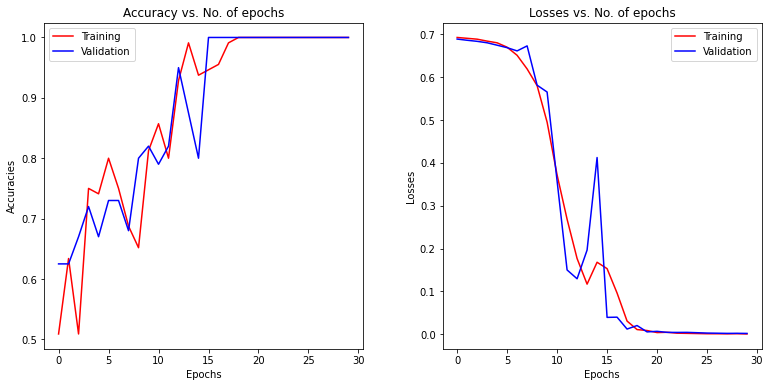

In [72]:
plot_results(history)

In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = alexnet_custom(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 100 %
